In [11]:
import os, gc, json, torch
import numpy as np
import evaluate
from datasets import DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,             # <--- Add
    Seq2SeqTrainingArguments,   # <--- Add
    DataCollatorForSeq2Seq,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
from torch.utils.data import DataLoader

# ------------------------------------------------------------------
# 0️⃣  CUDA + Memory Configuration
# ------------------------------------------------------------------
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# ------------------------------------------------------------------
# 1️⃣  Model + Tokenizer Setup
# ------------------------------------------------------------------
model_name = "Salesforce/codet5p-220m"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

print("🚀 Loading quantized model (4-bit)...")
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    add_bos_token=True,
    add_eos_token=True,
    use_fast=True,
)
# tokenizer.pad_token = tokenizer.eos_token
# Explicitly check if pad_token is missing before assigning
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token

# Ensure pad_token_id is an integer, not None
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print(f"⚠️ Pad Token was None, set to EOS ID: {tokenizer.pad_token_id}")
    
print(f"Tokenizer Pad Token: {tokenizer.pad_token}")
print(f"Tokenizer EOS Token: {tokenizer.eos_token}")
print("✅ Model & Tokenizer loaded.")

🚀 Loading quantized model (4-bit)...
Tokenizer Pad Token: <pad>
Tokenizer EOS Token: </s>
✅ Model & Tokenizer loaded.


In [12]:
# ------------------------------------------------------------------
# 2️⃣  Prepare for LoRA (k-bit training)
# ------------------------------------------------------------------
model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "k", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)
peft_model = get_peft_model(model, lora_config)
peft_model.config.use_cache = False

def print_trainable_parameters(model):
    trainable_params, all_param = 0, 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params:,} / {all_param:,} "
          f"({100 * trainable_params / all_param:.2f}%)")

print_trainable_parameters(peft_model)

Trainable params: 2,654,208 / 154,757,376 (1.72%)


In [13]:
# ------------------------------------------------------------------
# 3️⃣  Dataset Loading (FIXED for new dataset format)
# ------------------------------------------------------------------
def flatten_jsonl(path):
    fixed = []
    # Using utf-8 encoding is safer
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            obj = json.loads(line)

            # 1. Get the fields
            # We NO LONGER look for "context" as the new data doesn't have it.
            prompt = obj.get("prompt", "")
            output = obj.get("output", "")

            # 2. Flatten lists if necessary (safety check)
            if isinstance(prompt, list): prompt = " ".join(map(str, prompt))
            if isinstance(output, list): output = " ".join(map(str, output))

            # 3. Create combined input text
            # Format: "Prompt: <instruction>\nXML:"
            input_text = f"Prompt: {prompt.strip()}\nXML:".strip()

            fixed.append({
                "input_text": input_text,
                "output_text": str(output),
            })
    return fixed

# Update these paths to where your 'generate_unitime_data.py' saved the files
# Assuming relative path from where you run the script:
data_files = {
    "train": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/train.jsonl",
    "validation": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/validation.jsonl",
    "test": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/test.jsonl",
}

print("📂 Loading and flattening dataset...")
# Verify files exist
for k, v in data_files.items():
    if not os.path.exists(v):
        print(f"⚠️ Warning: File not found: {v}")

splits = {k: flatten_jsonl(v) for k, v in data_files.items()}

dataset_dict = DatasetDict({
    "train": Dataset.from_list(splits["train"]),
    "validation": Dataset.from_list(splits["validation"]),
    "test": Dataset.from_list(splits["test"]),
})
print(dataset_dict)

# ------------------------------------------------------------------
# 4️⃣  Tokenization
# ------------------------------------------------------------------
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 512

def tokenize_function(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length",
    )
    labels = tokenizer(
        batch["output_text"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length",
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("🧠 Tokenizing...")
tokenized_datasets = dataset_dict.map(
    tokenize_function,
    batched=True,
    remove_columns=["input_text", "output_text"],
)
print("✅ Tokenization complete.")

# ------------------------------------------------------------------
# 5️⃣  Evaluation Metrics
# ------------------------------------------------------------------
cer_metric = evaluate.load("cer")
bleu_metric = evaluate.load("sacrebleu")

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple) or (hasattr(preds, "ndim") and preds.ndim == 3):
#         pred_ids = np.argmax(preds, axis=-1)
#     else:
#         pred_ids = preds
#     labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
#     decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     exact_match = np.mean([p.strip() == l.strip() for p, l in zip(decoded_preds, decoded_labels)])
#     cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
#     decoded_labels_for_bleu = [[label] for label in decoded_labels]
#     bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_for_bleu)
    
#     return {
#         "exact_match": round(float(exact_match), 4),
#         "cer": round(float(cer), 4),
#         "bleu": round(float(bleu["score"]), 4),
#     }
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    # 1. Handle tuple predictions (some models return (logits, past_key_values))
    if isinstance(preds, tuple):
        preds = preds[0]
        
    # 2. Convert to numpy if not already (safety check)
    if not isinstance(preds, np.ndarray):
        preds = np.array(preds)
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)

    # 3. Replace -100 in LABELS with pad_token_id (Critical for Loss masking)
    #    -100 is used to ignore tokens during loss calculation, but crashes the decoder.
    decoded_labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # 4. Replace -100 in PREDICTIONS (Critical safety net)
    #    Sometimes generation produces -100 or garbage if not configured right.
    decoded_preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    # 5. Decode
    #    skip_special_tokens=True removes <pad>, <s>, </s> automatically
    decoded_preds = tokenizer.batch_decode(decoded_preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(decoded_labels, skip_special_tokens=True)

    # 6. Clean up text (trim whitespace)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # 7. Metrics Calculation
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])
    
    # Handle edge case: Empty strings can crash CER
    # We replace empty strings with a single space if necessary, or just let metric handle it
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    # BLEU expects references as list of lists
    decoded_labels_for_bleu = [[label] for label in decoded_labels]
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_for_bleu)
    
    return {
        "exact_match": round(float(exact_match), 4),
        "cer": round(float(cer), 4),
        "bleu": round(float(bleu["score"]), 4),
    }    

📂 Loading and flattening dataset...
DatasetDict({
    train: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 1750
    })
    validation: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 375
    })
    test: Dataset({
        features: ['input_text', 'output_text'],
        num_rows: 375
    })
})
🧠 Tokenizing...


Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

Map:   0%|          | 0/375 [00:00<?, ? examples/s]

Map:   0%|          | 0/375 [00:00<?, ? examples/s]

✅ Tokenization complete.


In [ ]:
# # ------------------------------------------------------------------
# # 6️⃣  Training Arguments (memory-safe)
# # ------------------------------------------------------------------
# output_dir = "./Preference-nlp-to-xml_1st"
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=7,
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=8,
#     warmup_steps=1,
#     weight_decay=0.01,
#     learning_rate=2e-4,
#     optim="paged_adamw_8bit",
#     logging_dir="./logs",
#     logging_steps=30,
    
#     # Validation settings
#     eval_strategy="yes",
#     do_eval=False,
    
#     # Checkpointing
#     save_strategy="steps",
#     save_steps=100,
    
#     gradient_checkpointing=True,
#     load_best_model_at_end=False,
#     fp16=True,
#     report_to="none",
#     remove_unused_columns=False,
# )

# print("✅ TrainingArguments configured.")

# # ------------------------------------------------------------------
# # 7️⃣  Trainer
# # ------------------------------------------------------------------
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=peft_model, padding="longest")

# trainer = Trainer(
#     model=peft_model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# # ------------------------------------------------------------------
# # 8️⃣  Training (with cleanup)
# # ------------------------------------------------------------------
# def pre_train_cleanup():
#     gc.collect()
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

# pre_train_cleanup()

# print("\n🔥 Starting fine-tuning (memory-safe QLoRA)...")
# trainer.train()
# print("🎉 Fine-tuning complete!")

# # Save the final adapter
# final_adapter_path = os.path.join(output_dir, "final_adapter")
# trainer.save_model(final_adapter_path)
# print(f"💾 Adapter saved to: {final_adapter_path}")

# ------------------------------------------------------------------
# 6️⃣  Training Arguments (Updated for Evaluation)
# ------------------------------------------------------------------
output_dir = "./Preference-nlp-to-xml_2nd"

training_args = Seq2SeqTrainingArguments(  # <--- Changed class
    output_dir=output_dir,
    num_train_epochs=9,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,    # <--- Add eval batch size
    gradient_accumulation_steps=8,
    warmup_steps=1,
    weight_decay=0.01,
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_dir="./logs",
    logging_steps=30,

    # --- Evaluation Settings ---
    eval_strategy="steps",     # Evaluate every X steps
    eval_steps=50,                  # Match this with save_steps usually
    do_eval=True,                    # <--- MUST be True
    predict_with_generate=True,      # <--- CRITICAL: Generates text for BLEU/CER
    generation_max_length=512,       # Limit generation length during eval
    
    # Checkpointing & Saving
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,     # Optional: Load best model based on metric
    metric_for_best_model="cer",     # Optional: Monitor CER
    greater_is_better=False,         # Optional: Lower CER is better

    gradient_checkpointing=True,
    fp16=True,
    report_to="none",
    remove_unused_columns=False,
)

# ------------------------------------------------------------------
# 7️⃣  Trainer (Updated to Seq2SeqTrainer)
# ------------------------------------------------------------------
data_collator = DataCollatorForSeq2Seq(tokenizer, model=peft_model, padding="longest")

trainer = Seq2SeqTrainer(            # <--- Changed Class
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


# # ------------------------------------------------------------------
# # 8️⃣  Training (with cleanup)
# # ------------------------------------------------------------------
def pre_train_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

pre_train_cleanup()

print("\n🔥 Starting fine-tuning (memory-safe QLoRA)...")
trainer.train()
print("🎉 Fine-tuning complete!")

# Save the final adapter
final_adapter_path = os.path.join(output_dir, "final_adapter")
trainer.save_model(final_adapter_path)
print(f"💾 Adapter saved to: {final_adapter_path}")

/tmp/ipykernel_1277901/693901939.py:111: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(            # <--- Changed Class



🔥 Starting fine-tuning (memory-safe QLoRA)...


Step,Training Loss,Validation Loss,Exact Match,Cer,Bleu
50,4.244100,4.135072,0.808000,0.040600,93.841900
100,4.228400,4.133172,0.864000,0.023400,96.323000



📈 Generating Learning Curves...
✅ Learning curve saved to: ./Preference-nlp-to-xml_2nd/learning_curve.png


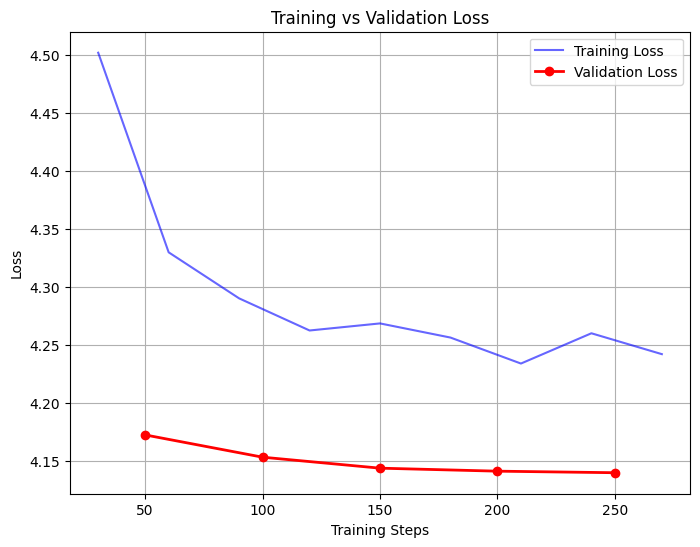

In [24]:
import matplotlib.pyplot as plt  # <--- Re-import ensures 'plt' is the module, not a function

# ------------------------------------------------------------------
# 📊 Plotting Learning Curves
# ------------------------------------------------------------------
print("\n📈 Generating Learning Curves...")

# 1. Extract logs from trainer history
# 'trainer' must be defined from your previous training cell
history = trainer.state.log_history

train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for log in history:
    # Extract training loss
    if "loss" in log and "step" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    
    # Extract validation loss (only present if do_eval=True)
    if "eval_loss" in log and "step" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

# 2. Create the plot
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.6, color="blue")

# Plot validation loss (if available)
if eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", alpha=1.0, color="red", linewidth=2, marker='o')

plt.title("Training vs Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Save the plot to a file
plot_path = os.path.join(output_dir, "learning_curve.png")
plt.savefig(plot_path)
print(f"✅ Learning curve saved to: {plot_path}")

# Display the plot in the notebook
plt.show()

In [ ]:
# ... (after trainer.save_model) ...

# ------------------------------------------------------------------
# 9️⃣  Final Evaluation on Test Set
# ------------------------------------------------------------------
print("\n📊 Running evaluation on the Test set...")

# Run evaluation
metrics = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

print("\n--- Test Set Metrics ---")
print(f"Refined BLEU:  {metrics['eval_bleu']}")
print(f"Refined CER:   {metrics['eval_cer']}")
print(f"Exact Match:   {metrics['eval_exact_match']}")
print("------------------------")

In [ ]:
# # ------------------------------------------------------------------
# # 9️⃣ Manual Evaluation (Validation Set)
# # ------------------------------------------------------------------
# print("\n📊 Running manual evaluation (memory-safe)...")

# # Set model to evaluation mode
# peft_model.eval()

# eval_dataset = tokenized_datasets["validation"]
# eval_loader = DataLoader(eval_dataset, batch_size=1, collate_fn=data_collator)

# all_preds, all_labels = [], []

# for batch in eval_loader:
#     input_ids = batch["input_ids"].to("cuda")
#     attention_mask = batch["attention_mask"].to("cuda")
#     labels = batch["labels"].numpy()

#     with torch.no_grad():
#         generated_ids = peft_model.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=512,
#             num_beams=1,
#             pad_token_id=tokenizer.pad_token_id
#         )
    
#     preds = generated_ids.cpu().numpy()
    
#     # --- Padding Fix ---
#     label_length = labels.shape[1]
#     padded_preds = np.full((preds.shape[0], label_length), tokenizer.pad_token_id)
#     copy_length = min(preds.shape[1], label_length)
#     padded_preds[:, :copy_length] = preds[:, :copy_length]
    
#     all_preds.extend(padded_preds)
#     all_labels.extend(labels)

#     # Cleanup
#     del input_ids, attention_mask, labels, batch, generated_ids, preds, padded_preds
#     gc.collect()
#     torch.cuda.empty_cache()

# print("...Evaluation complete. Computing metrics.")
# metrics = compute_metrics((np.array(all_preds), np.array(all_labels)))
# print("📊 Evaluation metrics:", metrics)



📊 Running manual evaluation (memory-safe)...
...Evaluation complete. Computing metrics.
📊 Evaluation metrics: {'exact_match': 0.0, 'cer': 0.1723, 'bleu': 79.1321}


In [ ]:
# # ------------------------------------------------------------------
# # 🔟 Inference Check (Reloading Base + Adapter)
# # ------------------------------------------------------------------
# print("\n🔄 Reloading model for inference check...")

# # Clean up memory first
# del peft_model, model, trainer
# gc.collect()
# torch.cuda.empty_cache()

# # Load Base Model Again
# model = AutoModelForSeq2SeqLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     device_map="auto",
#     trust_remote_code=True,
# )

# # Load the Adapter we just saved
# print(f"Loading adapter from: {final_adapter_path}")
# model = PeftModel.from_pretrained(model, final_adapter_path)
# model.eval()

# # Define Input - MATCHING TRAINING FORMAT EXACTLY
# prompt_text = "For instructor JOE DOE, make the time slot T 1630-1830 required."
# input_text = f"Prompt: {prompt_text.strip()}\nXML:"

# print(f"Input to model:\n{input_text}")
# inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

# print("...Generating XML...")
# with torch.no_grad():
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=512,
#         num_beams=4,
#         early_stopping=True,
#         pad_token_id=tokenizer.pad_token_id,
#         eos_token_id=tokenizer.eos_token_id
#     )

# xml_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print("\n--- Generated XML ---")
# print(xml_output)
# ------------------------------------------------------------------
# 🔟 Inference Check (Reloading Base + Adapter)
# ------------------------------------------------------------------
print("\n🔄 Reloading model for inference check...")

# # Clean up memory first
# del peft_model, model, trainer
# gc.collect()
# torch.cuda.empty_cache()

# Load Base Model Again
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Load the Adapter we just saved
print(f"Loading adapter from: {final_adapter_path}")
model = PeftModel.from_pretrained(model, final_adapter_path)
model.eval()

# Define Input
prompt_text = "For instructor JOE DOE, make the time slot T 1630-1830 required."
input_text = f"Prompt: {prompt_text.strip()}\nXML:"

print(f"Input to model:\n{input_text}")
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

print("...Generating XML...")
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

# Decode
xml_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- THE FIX IS HERE ---
# Manually remove the artifact if it persists
xml_output = xml_output.replace("<pad>", "").strip()

print("\n--- Generated XML ---")
print(xml_output)


🔄 Reloading model for inference check...
Loading adapter from: ./Preference-nlp-to-xml_1st/final_adapter
Input to model:
Prompt: For instructor JOE DOE, make the time slot T 1630-1830 required.
XML:
...Generating XML...

--- Generated XML ---
<preferences term="Fal" year="2010" campus="woebegon" dateFormat="yyyy/M/d" timeFormat="HHmm" created="Sun Dec 07 01:16:06 IST 2025">
<instructor externalId="100" firstName="JOE" lastName="DOE" department="0101">
<timePref level="R">
<pref level="R" day="T" start="1630" stop="1830"/>
</timePref>
</instructor>
</preferences>


In [ ]:
# import os, gc, json, torch
# import numpy as np
# import evaluate
# from datasets import DatasetDict, Dataset
# from transformers import (
#     AutoTokenizer,
#     AutoModelForSeq2SeqLM,
#     Trainer,
#     TrainingArguments,
#     DataCollatorForSeq2Seq,
#     BitsAndBytesConfig,
# )
# from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
# from torch.utils.data import DataLoader

# # ------------------------------------------------------------------
# # 0️⃣  CUDA + Memory Configuration
# # ------------------------------------------------------------------
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# # ------------------------------------------------------------------
# # 1️⃣  Model + Tokenizer Setup
# # ------------------------------------------------------------------
# model_name = "Salesforce/codet5p-220m"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_use_double_quant=False,
# )

# print("🚀 Loading quantized model (4-bit)...")
# model = AutoModelForSeq2SeqLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     device_map="auto",
#     trust_remote_code=True,
# )

# tokenizer = AutoTokenizer.from_pretrained(
#     model_name,
#     trust_remote_code=True,
#     add_bos_token=True,
#     add_eos_token=True,
#     use_fast=False,
# )
# tokenizer.pad_token = tokenizer.eos_token
# print("✅ Model & Tokenizer loaded.")

# # ------------------------------------------------------------------
# # 2️⃣  Prepare for LoRA (k-bit training)
# # ------------------------------------------------------------------
# model = prepare_model_for_kbit_training(model)
# model.gradient_checkpointing_enable()

# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=["q", "k", "v"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type=TaskType.SEQ_2_SEQ_LM,
# )
# peft_model = get_peft_model(model, lora_config)
# peft_model.config.use_cache = False

# def print_trainable_parameters(model):
#     trainable_params, all_param = 0, 0
#     for _, param in model.named_parameters():
#         all_param += param.numel()
#         if param.requires_grad:
#             trainable_params += param.numel()
#     print(f"Trainable params: {trainable_params:,} / {all_param:,} "
#           f"({100 * trainable_params / all_param:.2f}%)")

# print_trainable_parameters(peft_model)

# # ------------------------------------------------------------------
# # 3️⃣  Dataset Loading (FIXED for new dataset format)
# # ------------------------------------------------------------------
# def flatten_jsonl(path):
#     fixed = []
#     # Using utf-8 encoding is safer
#     with open(path, 'r', encoding='utf-8') as f:
#         for line in f:
#             if not line.strip():
#                 continue
#             obj = json.loads(line)

#             # 1. Get the fields
#             # We NO LONGER look for "context" as the new data doesn't have it.
#             prompt = obj.get("prompt", "")
#             output = obj.get("output", "")

#             # 2. Flatten lists if necessary (safety check)
#             if isinstance(prompt, list): prompt = " ".join(map(str, prompt))
#             if isinstance(output, list): output = " ".join(map(str, output))

#             # 3. Create combined input text
#             # Format: "Prompt: <instruction>\nXML:"
#             input_text = f"Prompt: {prompt.strip()}\nXML:".strip()

#             fixed.append({
#                 "input_text": input_text,
#                 "output_text": str(output),
#             })
#     return fixed

# # Update these paths to where your 'generate_unitime_data.py' saved the files
# # Assuming relative path from where you run the script:
# data_files = {
#     "train": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/train.jsonl",
#     "validation": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/validation.jsonl",
#     "test": "/home/sysadm/Music/unitime/unitime_nlp/data/Preferences_dataset/test.jsonl",
# }

# print("📂 Loading and flattening dataset...")
# # Verify files exist
# for k, v in data_files.items():
#     if not os.path.exists(v):
#         print(f"⚠️ Warning: File not found: {v}")

# splits = {k: flatten_jsonl(v) for k, v in data_files.items()}

# dataset_dict = DatasetDict({
#     "train": Dataset.from_list(splits["train"]),
#     "validation": Dataset.from_list(splits["validation"]),
#     "test": Dataset.from_list(splits["test"]),
# })
# print(dataset_dict)

# # ------------------------------------------------------------------
# # 4️⃣  Tokenization
# # ------------------------------------------------------------------
# MAX_INPUT_LENGTH = 512
# MAX_TARGET_LENGTH = 512

# def tokenize_function(batch):
#     model_inputs = tokenizer(
#         batch["input_text"],
#         max_length=MAX_INPUT_LENGTH,
#         truncation=True,
#         padding="max_length",
#     )
#     labels = tokenizer(
#         batch["output_text"],
#         max_length=MAX_TARGET_LENGTH,
#         truncation=True,
#         padding="max_length",
#     )
#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# print("🧠 Tokenizing...")
# tokenized_datasets = dataset_dict.map(
#     tokenize_function,
#     batched=True,
#     remove_columns=["input_text", "output_text"],
# )
# print("✅ Tokenization complete.")

# # ------------------------------------------------------------------
# # 5️⃣  Evaluation Metrics
# # ------------------------------------------------------------------
# cer_metric = evaluate.load("cer")
# bleu_metric = evaluate.load("sacrebleu")

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple) or (hasattr(preds, "ndim") and preds.ndim == 3):
#         pred_ids = np.argmax(preds, axis=-1)
#     else:
#         pred_ids = preds
#     labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
#     decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     exact_match = np.mean([p.strip() == l.strip() for p, l in zip(decoded_preds, decoded_labels)])
#     cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
#     decoded_labels_for_bleu = [[label] for label in decoded_labels]
#     bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_for_bleu)
    
#     return {
#         "exact_match": round(float(exact_match), 4),
#         "cer": round(float(cer), 4),
#         "bleu": round(float(bleu["score"]), 4),
#     }

# # ------------------------------------------------------------------
# # 6️⃣  Training Arguments (memory-safe)
# # ------------------------------------------------------------------
# output_dir = "./Preference-nlp-to-xml_1st"
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=7,
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=8,
#     warmup_steps=1,
#     weight_decay=0.01,
#     learning_rate=2e-4,
#     optim="paged_adamw_8bit",
#     logging_dir="./logs",
#     logging_steps=30,
    
#     # Validation settings
#     eval_strategy="no",
#     do_eval=False,
    
#     # Checkpointing
#     save_strategy="steps",
#     save_steps=100,
    
#     gradient_checkpointing=True,
#     load_best_model_at_end=False,
#     fp16=True,
#     report_to="none",
#     remove_unused_columns=False,
# )

# print("✅ TrainingArguments configured.")

# # ------------------------------------------------------------------
# # 7️⃣  Trainer
# # ------------------------------------------------------------------
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=peft_model, padding="longest")

# trainer = Trainer(
#     model=peft_model,
#     args=training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )

# # ------------------------------------------------------------------
# # 8️⃣  Training (with cleanup)
# # ------------------------------------------------------------------
# def pre_train_cleanup():
#     gc.collect()
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()

# pre_train_cleanup()

# print("\n🔥 Starting fine-tuning (memory-safe QLoRA)...")
# trainer.train()
# print("🎉 Fine-tuning complete!")

# # Save the final adapter
# final_adapter_path = os.path.join(output_dir, "final_adapter")
# trainer.save_model(final_adapter_path)
# print(f"💾 Adapter saved to: {final_adapter_path}")

# # ------------------------------------------------------------------
# # 9️⃣ Manual Evaluation (Validation Set)
# # ------------------------------------------------------------------
# print("\n📊 Running manual evaluation (memory-safe)...")

# # Set model to evaluation mode
# peft_model.eval()

# eval_dataset = tokenized_datasets["validation"]
# eval_loader = DataLoader(eval_dataset, batch_size=1, collate_fn=data_collator)

# all_preds, all_labels = [], []

# for batch in eval_loader:
#     input_ids = batch["input_ids"].to("cuda")
#     attention_mask = batch["attention_mask"].to("cuda")
#     labels = batch["labels"].numpy()

#     with torch.no_grad():
#         generated_ids = peft_model.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=512,
#             num_beams=1,
#             pad_token_id=tokenizer.pad_token_id
#         )
    
#     preds = generated_ids.cpu().numpy()
    
#     # --- Padding Fix ---
#     label_length = labels.shape[1]
#     padded_preds = np.full((preds.shape[0], label_length), tokenizer.pad_token_id)
#     copy_length = min(preds.shape[1], label_length)
#     padded_preds[:, :copy_length] = preds[:, :copy_length]
    
#     all_preds.extend(padded_preds)
#     all_labels.extend(labels)

#     # Cleanup
#     del input_ids, attention_mask, labels, batch, generated_ids, preds, padded_preds
#     gc.collect()
#     torch.cuda.empty_cache()

# print("...Evaluation complete. Computing metrics.")
# metrics = compute_metrics((np.array(all_preds), np.array(all_labels)))
# print("📊 Evaluation metrics:", metrics)

# # ------------------------------------------------------------------
# # 🔟 Inference Check (Reloading Base + Adapter)
# # ------------------------------------------------------------------
# print("\n🔄 Reloading model for inference check...")

# # Clean up memory first
# del peft_model, model, trainer
# gc.collect()
# torch.cuda.empty_cache()

# # Load Base Model Again
# model = AutoModelForSeq2SeqLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     device_map="auto",
#     trust_remote_code=True,
# )

# # Load the Adapter we just saved
# print(f"Loading adapter from: {final_adapter_path}")
# model = PeftModel.from_pretrained(model, final_adapter_path)
# model.eval()

# # Define Input - MATCHING TRAINING FORMAT EXACTLY
# prompt_text = "For instructor JOE DOE, make the time slot T 1630-1830 required."
# input_text = f"Prompt: {prompt_text.strip()}\nXML:"

# print(f"Input to model:\n{input_text}")
# inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

# print("...Generating XML...")
# with torch.no_grad():
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=512,
#         num_beams=4,
#         early_stopping=True,
#         pad_token_id=tokenizer.pad_token_id,
#         eos_token_id=tokenizer.eos_token_id
#     )

# xml_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print("\n--- Generated XML ---")
# print(xml_output)